<a href="https://colab.research.google.com/github/praharaadhi/i-want-to-learn-pytorch/blob/main/I_want_to_learn_Pytorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to load and visualize public dataset
## Lets try with FashionMNIST, CIFAR10, and ImageNet

Check my Pytorch version.

In [1]:
import torch
print(torch.__version__)

2.2.1+cu121


Pytorch contains three great modules:
*   TorchText
*   TorchVision
*   TorchAudio

I will focus learning on TorchVision because my field study is Computer Vision.






In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

Load CIFAR10 dataset.

In [32]:
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights

image_size = 84

weights = ResNet18_Weights.IMAGENET1K_V1

# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(image_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(image_size),
#         # transforms.CenterCrop(image_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

# download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=weights.transforms(),
)

# download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=weights.transforms(),
)

Files already downloaded and verified
Files already downloaded and verified


Check the data dimension.

In [33]:
# check the data dimension.
print("Training data:", training_data.data.shape)
print("Training labels:", len(training_data.targets))
print("Test data:", test_data.data.shape)
print("Test labels:", len(test_data.targets))

Training data: (50000, 32, 32, 3)
Training labels: 50000
Test data: (10000, 32, 32, 3)
Test labels: 10000


The dataset will be stored into mini-batch.

In [34]:
from torch.utils.data import DataLoader

# here I wish to put large number but in reality...
batch_size = 64

# create data loaders that read batch of shuffled data.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Check the batch dimension.

In [35]:
# get the first batch.
for X, y in test_dataloader:
    # check the data dimension.
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


Get the class name.

In [16]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

Visualize the dataset.

Feature batch shape: torch.Size([64, 3, 84, 84])
Labels batch shape: torch.Size([64])


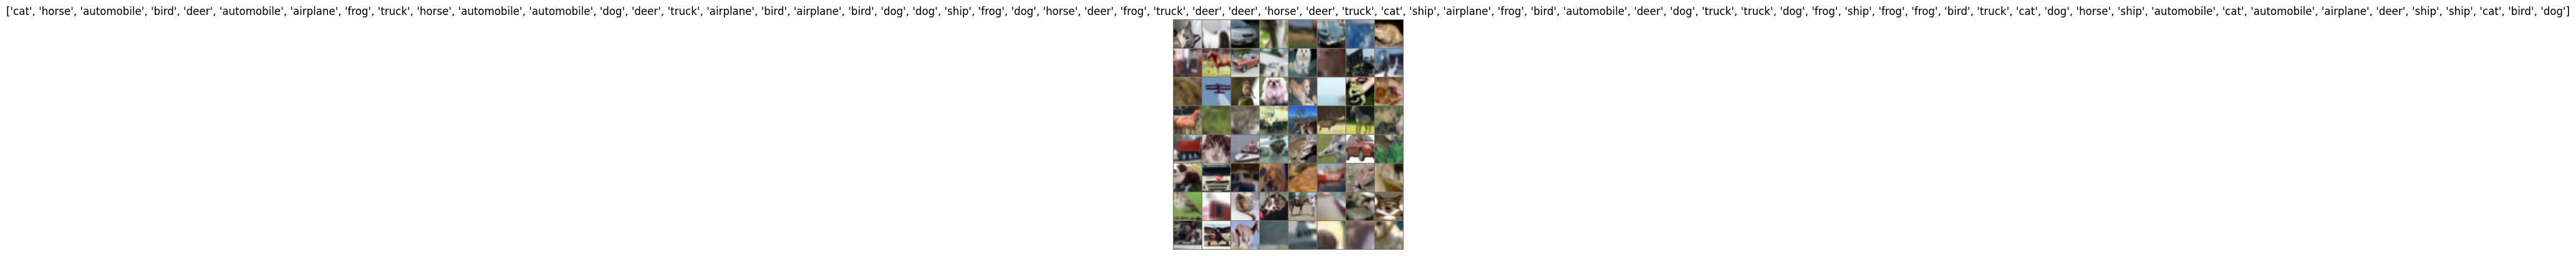

In [20]:
import torchvision

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# display image and label on the first batch.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# get the first image on batch and show it
out = torchvision.utils.make_grid(train_features)

imshow(out, title=[labels_map.get(x.item()) for x in train_labels])

In [36]:
import copy
import random
import math
import numpy as np
from statistics import mean

from torchvision import models
from torch import Tensor, nn, optim
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm

class CustomResnet18(torch.nn.Module):
    def __init__(self,
                 use_fc: bool = False,
                 num_classes: int = 2,
        ):
        super().__init__()

        self.model = models.resnet18(weights="IMAGENET1K_V1")

        self.use_fc = use_fc
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

        self.couches_before_fc = list(self.model.children())[:-1]
        self.resnet_before_fc = nn.Sequential(*self.couches_before_fc)
        # self.resnet_before_fc.fc = nn.Flatten()

    def forward(self, x: Tensor) -> Tensor:
        if self.use_fc:
            x = self.model(x)
        else:
            x = torch.flatten(self.resnet_before_fc(x), 1)
        return x

    def set_use_fc(self, use_fc: bool):
        """
        Change the use_fc property. Allow to decide when and where the model should use its last
        fully connected layer.
        Args:
            use_fc: whether to set self.use_fc to True or False
        """
        self.use_fc = use_fc

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

backbone_model = CustomResnet18(
    use_fc=True,
    num_classes=10,
)
backbone_model = backbone_model.to(device)

In [38]:
images, labels = next(iter(train_dataloader))
backbone_model.set_use_fc(True)
backbone_model.eval()
out = backbone_model(images)
print(out.size())
print(out[0])

torch.Size([64, 10])
tensor([ 0.5389, -1.0547, -1.0076, -0.0213, -0.6080,  0.4548, -0.0079, -0.5911,
        -0.1582, -1.2922], grad_fn=<SelectBackward0>)


In [40]:
backbone_model.set_use_fc(False)
backbone_model.eval()
out = backbone_model(images)
print(out.size())
print(out[0])

torch.Size([64, 512])
tensor([1.2204e+00, 2.2696e-01, 2.0374e-01, 1.6639e+00, 2.3480e-01, 9.1055e-01,
        4.5629e-01, 9.7487e-01, 3.5010e-01, 1.2743e+00, 2.1170e-02, 1.2273e+00,
        1.8678e-02, 4.0891e-01, 3.1697e-01, 1.3337e+00, 1.1912e+00, 1.8976e+00,
        1.2762e+00, 9.1759e-01, 9.7036e-01, 1.0480e-01, 1.5939e+00, 1.6189e-02,
        5.6279e-01, 8.0613e-01, 2.7832e+00, 3.1864e-01, 4.1359e+00, 1.8601e+00,
        6.9807e-01, 2.4453e+00, 1.1380e+00, 1.2698e-01, 2.0166e+00, 1.9818e+00,
        3.2764e-01, 6.7847e-01, 5.4063e-01, 1.8714e-02, 9.9328e-01, 1.0072e-01,
        1.0463e+00, 1.7384e+00, 4.4170e-01, 5.2617e-01, 2.4569e-01, 1.4292e-01,
        1.7588e+00, 4.7793e-01, 3.1135e-01, 1.8317e+00, 3.4604e-01, 1.5160e-01,
        4.0030e-01, 2.5226e-01, 4.9042e-01, 1.3821e+00, 7.4825e-01, 1.7553e+00,
        4.4060e-01, 2.0878e+00, 3.2050e-01, 2.5355e-02, 9.4681e-01, 8.4659e-02,
        0.0000e+00, 9.7222e-01, 2.7005e-02, 3.3559e-03, 3.2151e-01, 6.4266e-01,
        3.8149e-01

In [27]:
loss_function = nn.CrossEntropyLoss()

def training_epoch(model_: nn.Module, data_loader: DataLoader, optimizer: Optimizer):
    all_acc = []
    all_loss = []
    model_.train()

    with tqdm(data_loader, total=len(data_loader), desc="Training") as tqdm_train:
        # Iterate over data
        for images, labels in tqdm_train:
            # Sent to device
            timages = images.to(device)
            tlabels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model_(timages)
                _, preds = torch.max(outputs, 1)

                loss = loss_function(outputs, tlabels)
                loss.backward()
                optimizer.step()

            sum_corrects = torch.sum(preds == tlabels)
            all_acc.append(sum_corrects.item()/len(tlabels))
            all_loss.append(loss.item())

            tqdm_train.set_postfix_str(f'Train Loss: {mean(all_loss):.4f} Acc: {mean(all_acc):.4f}')

    return mean(all_acc), mean(all_loss)

In [28]:
# What to do with this hyperparams?
n_epochs = 20

# Set the optimizer
train_optimizer = SGD(backbone_model.parameters(), lr=0.01, momentum=0.9)

# Use scheduler learning rate
train_scheduler = StepLR(train_optimizer, step_size=10, gamma=0.1)

# Save the best model according to the validation result
best_state = backbone_model.state_dict()
best_val_acc = 0.0
best_train_acc = 0.0
best_train_loss = 1e5
val_interval = 10

# Training for several epochs
for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')

    train_acc, train_loss = training_epoch(backbone_model,
                                    train_dataloader,
                                    train_optimizer)

    # # Perform validation after a few epochs
    # if epoch % val_interval == val_interval - 1:

    #     # Set model to 'validation'
    #     backbone_model.set_use_fc(False)

    #     # Compute validation accuracy
    #     val_acc = evaluate(
    #         few_shot_classifier,
    #         val_loader,
    #         tqdm_prefix="Validate"
    #     )

    #     # Set model to 'training'
    #     backbone_model.set_use_fc(True)

    #     # If better than the previous best accuracy then save it
    #     if val_acc >= best_val_acc and (train_loss < best_train_loss or train_acc > best_train_acc):
    #         best_val_acc = val_acc
    #         best_train_acc = train_acc
    #         best_train_loss = train_loss
    #         best_state = copy.deepcopy(backbone_model.state_dict())
    #         print(f'Best Val Acc: {best_val_acc:.4f}')

    #     # Write to the log
    #     tb_writer.add_scalar("Val/acc", val_acc, epoch)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_state = copy.deepcopy(backbone_model.state_dict())
        print(f'Best Train Loss: {best_train_loss:.4f}')

    # Update scheduler
    train_scheduler.step()
    print()

# Load the best model
backbone_model.load_state_dict(best_state)

Epoch 1/20


Training: 100%|██████████| 782/782 [36:06<00:00,  2.77s/it, Train Loss: 1.0637 Acc: 0.6479]


Best Train Loss: 1.0637

Epoch 2/20


Training:  73%|███████▎  | 571/782 [26:17<09:42,  2.76s/it, Train Loss: 0.7896 Acc: 0.7326]


KeyboardInterrupt: 